# Sparse Hebbian Learning: basics

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.

Here, we will show the basic operations that are implemented in this package. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10
#matname = 'HAP_quantization'
homeo_method = 'HEH'
matname = homeo_method + '_quantization'
homeo_params = dict(eta_homeo=0.05, alpha_homeo=0.02, C=5., nb_quant=128, P_cum=None)
opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, homeo_method=homeo_method, homeo_params=homeo_params, verbose=verbose)

In [4]:
from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname='data')

Extracting data..No cache found /tmp/data_cache/data_data: Extracting data... Extracting data..bird08.png, yellowleaves39.png, rocky10.png, bittern62.png, flowerhill29.png, clouds43.png, goldwater67.png, calcoast09.png, yose05.png, woods54.png, koala52.png, bora04.png, flowers37.png, yose07.png, cattails70.png, hibiscus30.png, cucorn50.png, geyser27.png, reflection63.png, craterlake12.png, Data is of shape : (81920, 256) - done in 5.03s.
Data is of shape : (81920, 256) - done in 5.76s.


In [5]:
!ls -l {shl.data_cache}/{matname}*

ls: /tmp/data_cache/HEH_quantization*: No such file or directory


In [6]:
!ls -l {shl.data_cache}/{matname}*

ls: /tmp/data_cache/HEH_quantization*: No such file or directory


In [7]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 256)
average of patches =  -0.00019886110837833318  +/-  0.05942785266358504
average energy of data =  0.5953639765391074 +/- 0.5646953608649904


In [8]:
shl.do_precision

False

## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

No cache found /tmp/data_cache/HEH_quantization_dico.pkl: Learning the dictionary with algo = mp 
 Training on 81920 patches... Iteration   0 /   1024 (elapsed time:   0s,  0.0mn)
Iteration  103 /   1024 (elapsed time:  249s,  4.0mn)
Iteration  206 /   1024 (elapsed time:  445s,  7.0mn)
Iteration  309 /   1024 (elapsed time:  627s,  10.0mn)
Iteration  412 /   1024 (elapsed time:  833s,  13.0mn)
Iteration  515 /   1024 (elapsed time:  1038s,  17.0mn)
Iteration  618 /   1024 (elapsed time:  1238s,  20.0mn)
Iteration  721 /   1024 (elapsed time:  1445s,  24.0mn)
Iteration  824 /   1024 (elapsed time:  1653s,  27.0mn)
Iteration  927 /   1024 (elapsed time:  1859s,  30.0mn)
Learning code... done (total time:  2050s,  34.2mn)
done in 2050.57s.


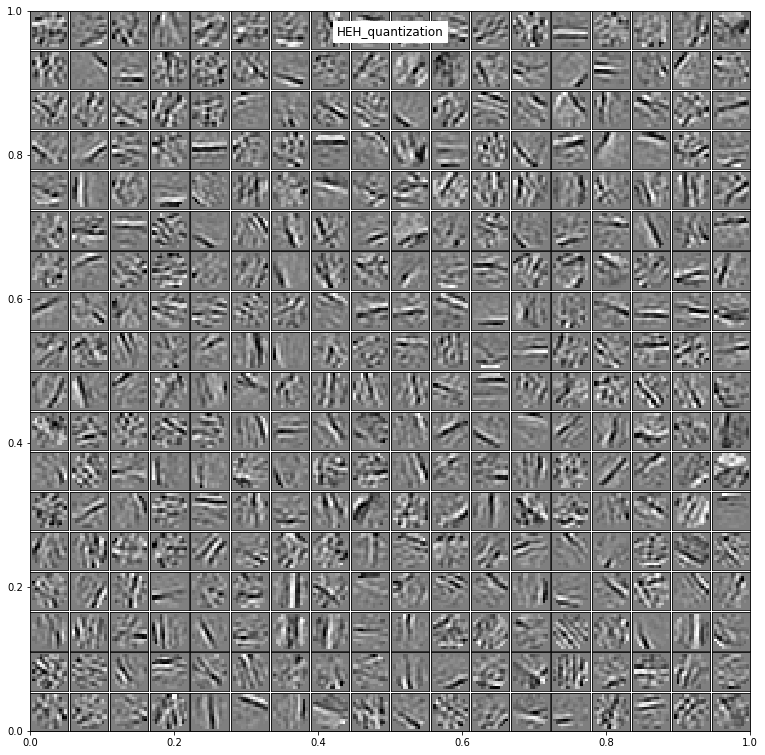

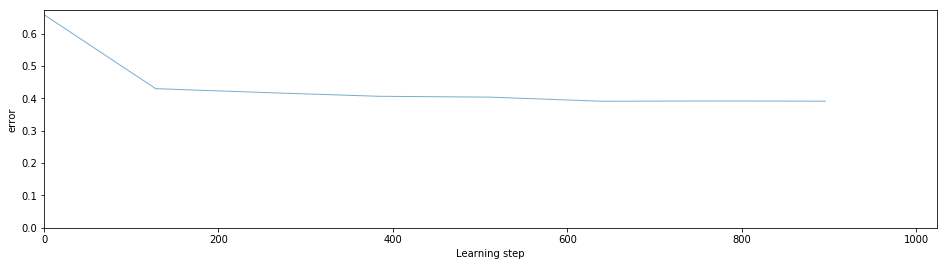

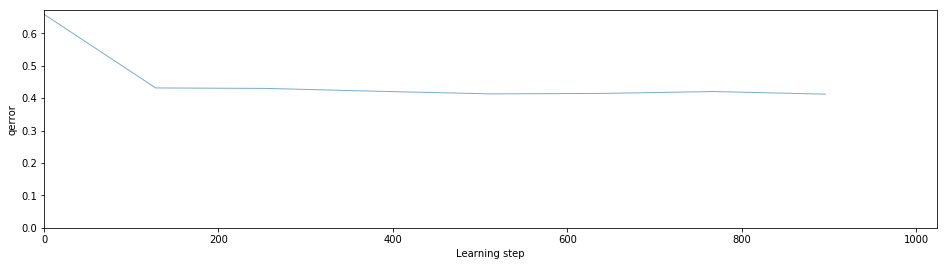

In [9]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_qerror']#, 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']

dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [10]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (324, 256)
average of filters =  -2.5483445682874215e-05 +/- 0.005221743858278909
average energy of filters =  1.0 +/- 8.831097003840249e-17


## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (512, 324)
average of codewords =  0.1210821737979984
l0-sparseness of codewords =  0.0914110725308642  ~= l0/M = 0.09259259259259259
average energy of codewords =  0.6165448405157516
std of the average of individual patches =  0.02967357861440449
number of codes, size of reconstructed images =  (512, 256)


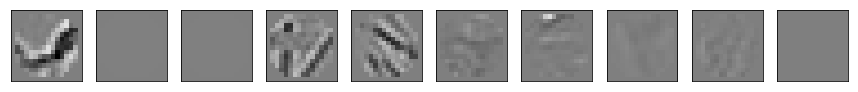

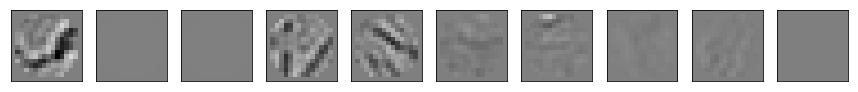

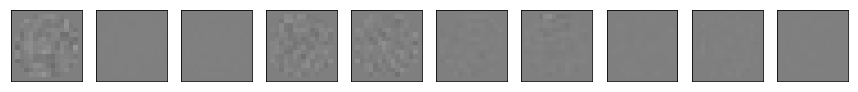

average of data patches =  -0.00019886110837833318 +/- 0.05942785266358504
average of residual patches =  0.0010702291928407518 +/- 0.018507650169810215
median energy of data =  0.5519118988682716
average energy of data =  0.5519118988682716 +/- 0.0
average energy of residual =  0.2139242902584023 +/- 0.0
median energy of residual =  0.2139242902584023
average gain of coding =  2.5799403059914754 +/- 0.0
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (512, 324)
average of codewords =  0.1210821737979984
l0-sparseness of codewords =  0.0914110725308642  ~= l0/M = 0.09259259259259259
average energy of codewords =  0.6165448405157515
std of the average of individual patches =  0.02967357861440449
number of codes, size of reconstructed images =  (512, 256)


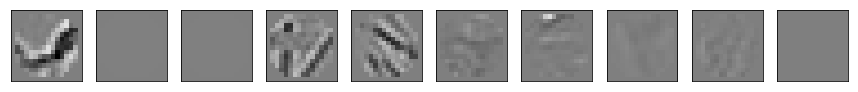

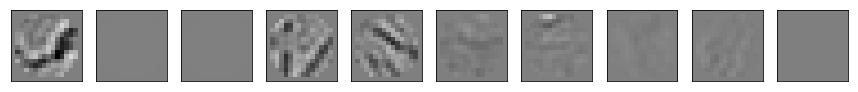

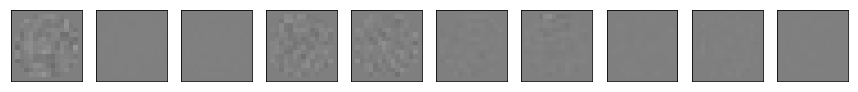

average of data patches =  -0.00019886110837833318 +/- 0.05942785266358504
average of residual patches =  0.001070229192840751 +/- 0.018507650169810215
median energy of data =  0.5519118988682716
average energy of data =  0.5519118988682716 +/- 0.0
average energy of residual =  0.2139242902584023 +/- 0.0
median energy of residual =  0.2139242902584023
average gain of coding =  2.5799403059914754 +/- 0.0
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (512, 324)
average of codewords =  0.12104025686593435
l0-sparseness of codewords =  0.09130859375  ~= l0/M = 0.09259259259259259
average energy of codewords =  0.6162480208089574
std of the average of individual patches =  0.029072089899400456
number of codes, size of reconstructed images =  (512, 256)


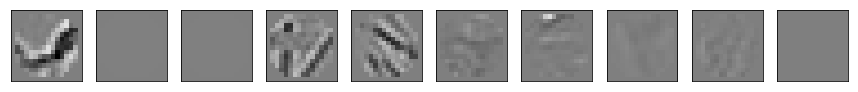

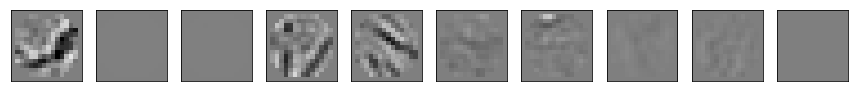

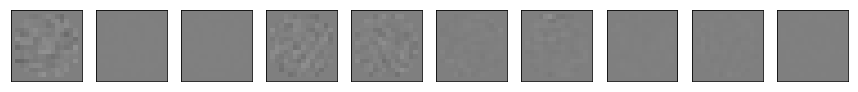

average of data patches =  -0.00019886110837833318 +/- 0.05942785266358504
average of residual patches =  0.0010175542028743418 +/- 0.02168782257478548
median energy of data =  0.5519118988682716
average energy of data =  0.5519118988682716 +/- 0.0
average energy of residual =  0.21498943980580398 +/- 0.0
median energy of residual =  0.21498943980580398
average gain of coding =  2.5671581793357086 +/- 0.0


In [11]:
from shl_scripts.shl_encode import mp
nb_quant = 128
record_num_batches = 512
np.random.seed(42)
indx = np.random.permutation(data.shape[0])[:record_num_batches]
#sparse_code = shl.code(data, dico, matname=matname)
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))
#P_cum = dico.P_cum
#P_cum = None
l0_sparseness = 200
l0_sparseness = shl.l0_sparseness
for P_cum, gain in zip([None, P_cum_zeroeffect, dico.P_cum], [np.ones(shl.n_dictionary), None, None]):
    print(50*'🐒')
    sparse_code = mp(data[indx, :], dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum, gain=gain)

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('average energy of codewords = ', sparse_code.std(axis=0).mean())
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

    patches = sparse_code @ dico.dictionary
    print('number of codes, size of reconstructed images = ', patches.shape)

    from shl_scripts.shl_tools import show_data
    max_patches = 10
    fig, axs = show_data(data[indx, :][:max_patches, :])
    plt.show()
    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    error = data[indx, :] - patches
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(data[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    #SD = np.sqrt(np.mean(data[indx, :]**2, axis=1))
    SD = np.linalg.norm(data[indx, :])/record_num_batches

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    #print('total energy of data = ', np.sqrt(np.sum(data**2)))
    #print('total deviation of data = ', np.sum(np.abs(data)))
    #SE = np.sqrt(np.mean(error**2, axis=1))
    SE = np.linalg.norm(error)/record_num_batches

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    #print('total energy of residual = ', np.sqrt(np.sum(error**2)))
    #print('total deviation of residual = ', np.sum(np.abs(error)))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

## Quantization of the coefficients

In [12]:
from shl_scripts.shl_learn import get_P_cum
C = 5.
P_cum = get_P_cum(sparse_code, C=C, nb_quant=nb_quant)
P_cum.shape

(324, 128)

In [13]:
P_cum = dico.P_cum
P_cum.shape

(324, 128)

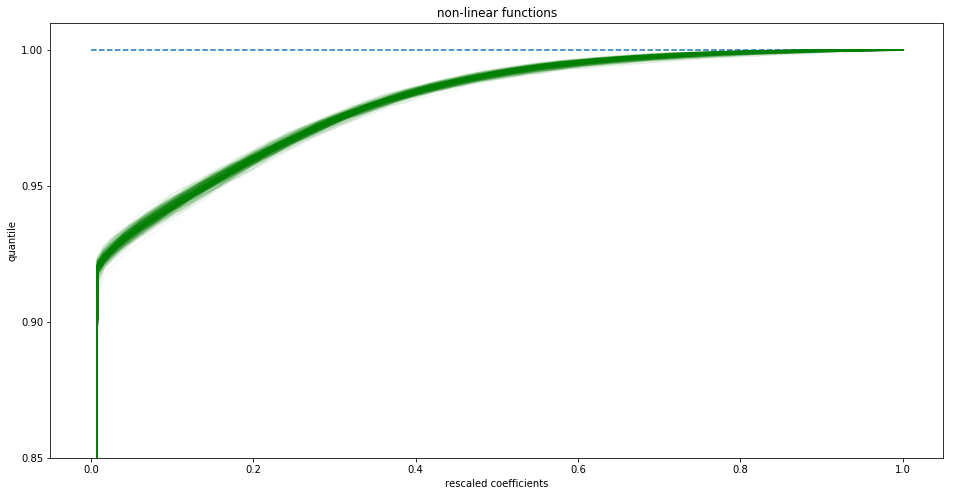

In [14]:
from shl_scripts.shl_tools import plot_P_cum
fig, ax = plot_P_cum(P_cum, verbose=False);
ax.set_ylim(0.85, 1.01);

In [15]:
P_cum.shape

(324, 128)

In [16]:
from shl_scripts.shl_encode import quantile, rescaling
#sparse_code = mp(data, dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum)
stick = np.arange(shl.n_dictionary)*nb_quant
q = quantile(P_cum, rescaling(sparse_code, C=C), stick, do_fast=True)

In [17]:
from shl_scripts.shl_encode import inv_quantile, inv_rescaling
q_sparse_code = inv_rescaling(inv_quantile(P_cum, q), C=C)
print('total deviation of coefficients = ', np.mean(np.abs(q_sparse_code-sparse_code)))

total deviation of coefficients =  0.0015896483253355007


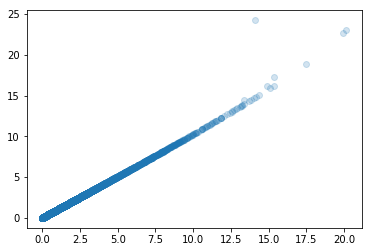

In [18]:
plt.scatter(sparse_code.ravel(), q_sparse_code.ravel(), alpha=.2);

In [19]:
P_cum.mean(axis=0).shape

(128,)

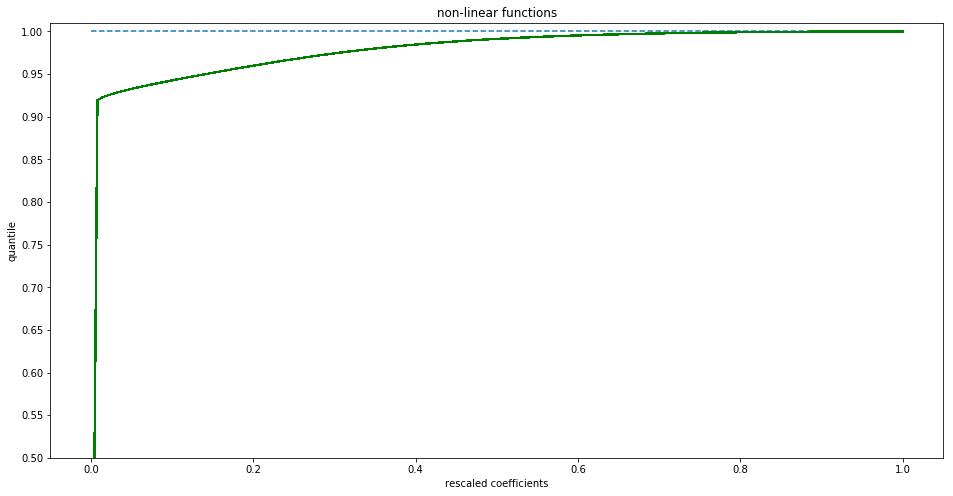

In [20]:
P_cum_mean = P_cum.mean(axis=0)[np.newaxis, :] * np.ones((shl.n_dictionary, nb_quant))
fig, ax = plot_P_cum(P_cum_mean, verbose=False);
ax.set_ylim(0.5, 1.01);

In [21]:
#q_sparse_code = inv_rescaling(inv_quantile(P_cum_mean, q), C=C)
q_sparse_code = inv_rescaling(inv_quantile(P_cum_mean, q), C=C)
print('total deviation of coefficients = ', np.mean(np.abs(sparse_code)))
print('total deviation of coefficients = ', np.mean(np.abs(q_sparse_code-sparse_code)))

total deviation of coefficients =  0.12104025686593435
total deviation of coefficients =  0.006937860708933165


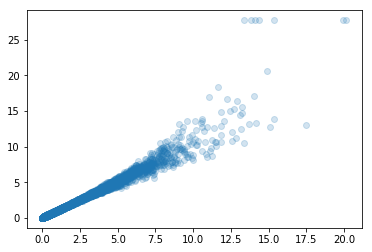

In [22]:
plt.scatter(sparse_code.ravel(), q_sparse_code.ravel(), alpha=.2);

average of data patches =  -0.00019886110837833318 +/- 0.05942785266358504
average of residual patches =  0.0010888556600909846 +/- 0.024274449941117535
median energy of data =  0.5519118988682716
average energy of data =  0.5519118988682716 +/- 0.0
average energy of residual =  0.23005609618439515 +/- 0.0
median energy of residual =  0.23005609618439515
average gain of coding =  2.399031836243547 +/- 0.0


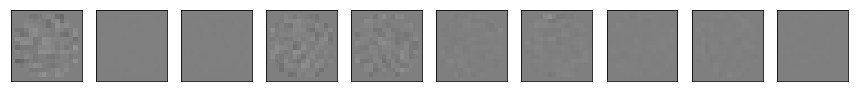

In [23]:
patches = q_sparse_code @ dico.dictionary
error = data[indx, :] - patches
fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(data[:max_patches, :])))
print('average of data patches = ', data.mean(), '+/-', data.mean(axis=1).std())
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
#SD = np.sqrt(np.mean(data[indx, :]**2, axis=1))
SD = np.linalg.norm(data[indx, :])/record_num_batches
print('median energy of data = ', np.median(SD))
print('average energy of data = ', SD.mean(), '+/-', SD.std())
#print('total energy of data = ', np.sqrt(np.sum(data**2)))
#print('total deviation of data = ', np.sum(np.abs(data)))
#SE = np.sqrt(np.mean(error**2, axis=1))
SE = np.linalg.norm(error)/record_num_batches

print('average energy of residual = ', SE.mean(), '+/-', SE.std())
print('median energy of residual = ', np.median(SE))
#print('total energy of residual = ', np.sqrt(np.sum(error**2)))
#print('total deviation of residual = ', np.sum(np.abs(error)))
print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

In [24]:
P_cum[0, -2]

0.999999999999999

## Version used

In [25]:
%load_ext version_information
%version_information numpy, shl_scripts

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.3.0 x86_64 i386 64bit
numpy 1.14.0
shl_scripts 20171221
Wed Jan 31 07:37:57 2018 CET